# Modeling Yelp Data

Paul Lim

## Libraries

In [1]:
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# sklearn
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import pipeline, feature_selection, decomposition
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.externals import joblib
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# NLP 
from nltk.corpus import stopwords
from textblob import TextBlob
import spacy

# Misc.
import re
import datetime
import time
import logging
import math

% matplotlib inline

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
sns.set_style({'legend.frameon': True})

## Running List of Functions/Classes

### Classes

In [56]:
class DataframeToSeries(BaseEstimator, TransformerMixin):
        
    def __init__(self, col=None):
        self.col = col
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.col:
            return X[self.col]
        else:
            return X
        
class SeparateFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols=None):
        self.num_cols = num_cols
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_cols:
            return X.loc[:, self.num_cols]
        else:
            return X
        
class WilsonAverageTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_col=None, biz_list=None):
        self.num_col = num_col
        self.biz_list = biz_list
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_col and self.biz_list.all():
            scores = get_average_rating(X, self.biz_list)
            
            X_avg = pd.DataFrame({'average': scores})
            
            return X_avg
        else:
            return X
        
class CleanText(BaseEstimator, TransformerMixin):

    def __init__(self, text_col=None):
        self.text_col = text_col
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        NLP = spacy.load('en')
        
        if self.text_col:
            df = pd.DataFrame()
            clean_review_list = []
            
            for review in X.loc[:, self.text_col]:
                clean_review = ''
                
                for word in NLP(review):
                    if word.is_stop == False:
                        clean_review += word.lemma_ + ' '
                        
#                 clean_review = NLP(clean_review)
                clean_review_list.append(clean_review)
                        
            df['clean_reviews'] = clean_review_list
            
            return df
        else:
            return X
        
class DensifyTransform(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.toarray()

### Functions

In [3]:
def confidence(pos, neg):
    '''
    Calculates the Wilson confidence where pos is the number of positive ratings
    and neg is the number of negative ratings.
    '''
    n = pos + neg
    
    if n == 0:
        return 0
    z = 1.96 # 95% confidence interval
    phat = float(pos) / n
    return (((phat + z*z/(2*n) - z * np.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n)))

def get_average_rating(df, biz_list):
    '''
    Compiles the list of average ratings for each business in biz_list.
    '''
    wils_list = []
    
    for biz in biz_list:
        ind_biz = df[df['name'] == biz]
        
        pos_count = 0
        neg_count = 0
        
        for rating in ind_biz['rating']:
            if rating > 3:
                pos_count += 1
            else:
                neg_count += 1
        
        wils_conf = confidence(pos_count, neg_count)
        wils_list.append(wils_conf)
    return wils_list

## Data Preprocessing

### Load in data

In [4]:
df_init = joblib.load('../data/df_tot')

### Reorder columns

In [5]:
df_init = df_init[['name', 'rating' ,'reviews']]

### Change rating to int type

In [6]:
df_init['rating'] = df_init['rating'].apply(lambda x: int(x))

### Create holdout set

In [7]:
df_shuffled = df_init.sample(frac=1)

holdout_size = round(len(df_shuffled)*0.2)

df_holdout = df_shuffled.iloc[:holdout_size, :]
df_model = df_shuffled.iloc[holdout_size:, :]

print("Holdout Size: ", len(df_holdout))
print("CV Size: ", len(df_model))

Holdout Size:  40939
CV Size:  163757


### Sort the dataframe for cross-validation

In [8]:
df_model = df_model.sort()

/Users/plim0793/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


### Create transformers for splitting text and num columns

In [10]:
t = SeparateFeatures(['reviews'])
n = SeparateFeatures()

print(t.transform(df_model).head())
print(n.transform(df_model).head())

                                             reviews
0  Hipster coffee galore! What happened to just a...
1  A pretty hipster, modern spacious place to do ...
2  Great place to grab a coffee and you can get t...
3  Coffee is amazing! Overpriced as usual. There'...
4  Big time coffee lover. First time customer and...
                 name  rating  \
0  0_FourBarrelCoffee       2   
1  0_FourBarrelCoffee       4   
2  0_FourBarrelCoffee       5   
3  0_FourBarrelCoffee       4   
4  0_FourBarrelCoffee       4   

                                             reviews  
0  Hipster coffee galore! What happened to just a...  
1  A pretty hipster, modern spacious place to do ...  
2  Great place to grab a coffee and you can get t...  
3  Coffee is amazing! Overpriced as usual. There'...  
4  Big time coffee lover. First time customer and...  


In [11]:
t.transform(df_model).shape
n.transform(df_model).shape

(163757, 3)

### Create transformer for averaging ratings for each business (may not need this since I might not average across the each business)

#### Get Wilson average for one business

In [12]:
one_biz = df_model[df_model['name'] == '0_FourBarrelCoffee']

In [13]:
pos_count = 0
neg_count = 0

for rating in one_biz['rating']:
    if rating > 3:
        pos_count += 1
    else:
        neg_count += 1
        
wil_conf = confidence(pos_count, neg_count)

#### Generalize to all businesses

In [14]:
biz_list = df_model['name'].unique()

In [15]:
wils_scores = get_average_rating(df_model, biz_list)

#### Create the transformer class

In [16]:
wat = WilsonAverageTransformer(num_col='rating', biz_list=biz_list)

In [17]:
wat.transform(df_model)

,average
0,0.717901
1,0.858098
2,0.795028
3,0.732776
4,0.811068
5,0.790576
6,0.719914
7,0.891296
8,0.564857
9,0.922868


### Create a transformer for preprocessing the reviews

#### Get the lemmatized review for just one review

In [18]:
one_review = df_model.iloc[0, 2]

In [19]:
nlp = spacy.load('en')

In [20]:
sample_doc = nlp(one_review)

In [21]:
clean_doc = ''
for word in sample_doc:
    if word.is_stop == False:
        clean_doc += word.lemma_ + ' '
clean_doc = nlp(clean_doc)

In [22]:
for sent in clean_doc.sents:
    print(sent)

hipster coffee galore ! happen good ol cup joe ?
need expensive ?
line long , figure coffee mind blow .
impressed . enjoy !


#### Generalize to all reviews

In [23]:
test_df = df_model.iloc[:100, :]

In [24]:
ct = CleanText('reviews')

test_ct = ct.transform(test_df)

In [25]:
tf = TfidfVectorizer()

tf_t = tf.fit_transform(test_ct.clean_reviews)

In [26]:
tf_t.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [27]:
type(test_ct.clean_reviews[0])

str

In [28]:
print(test_ct.clean_reviews[0])

hipster coffee galore ! happen good ol cup joe ? need expensive ? line long , figure coffee mind blow . impressed . enjoy ! 


## Build the Pipeline

In [62]:
DB_baseline = Pipeline([
        ('combined_features', FeatureUnion([
                    
            ('split_num', SeparateFeatures(num_cols=['rating'])),
            ('text_vect', Pipeline([
                                
                ('split_text', SeparateFeatures()),
                ('to_series', DataframeToSeries(col='reviews')),
                ('tfidf', TfidfVectorizer()),
                ('densify', DensifyTransform())
            ]))           
        ])),
        ('pca', PCA(n_components=2)),
        ('model', DBSCAN())
    ])

### Since the entire pipeline is crashing the kernel, the pipeline will be broken down into steps

#### Set a smaller test dataframe

In [10]:
test_df = df_model.iloc[:500, :]

#### Set the text processing steps

In [38]:
text_processing = Pipeline([
                ('clean', CleanText('reviews')),
                ('to_series', DataframeToSeries(col='clean_reviews')),
                ('tfidf', TfidfVectorizer())
            ])

In [39]:
tp = text_processing.fit_transform(test_df)
tp_dense = tp.todense()
tp_dense[0].shape

(1, 3626)

#### Run PCA with 2 latent features

In [34]:
pca = PCA(n_components=2)

In [42]:
tpm = pca.fit_transform(tp_dense)

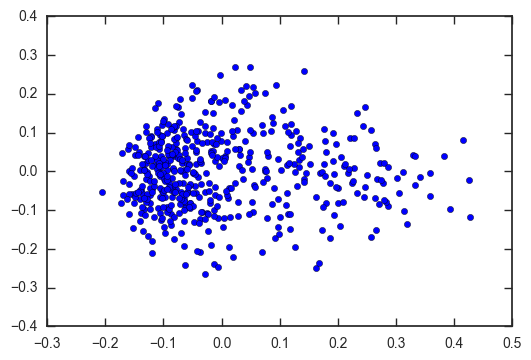

In [43]:
plt.scatter(tpm[:,0], tpm[:,1])

In [44]:
print(pca.explained_variance_ratio_)

[ 0.01798397  0.00984968]


#### Try various numbers of latent features

In [49]:
pca_range = [i for i in range(50)]
pca_variances = []

for num in pca_range:
    pca_obj = PCA(n_components=num)
    pca_fit = pca_obj.fit_transform(tp_dense)
    pca_variances.append(pca_obj.explained_variance_ratio_)

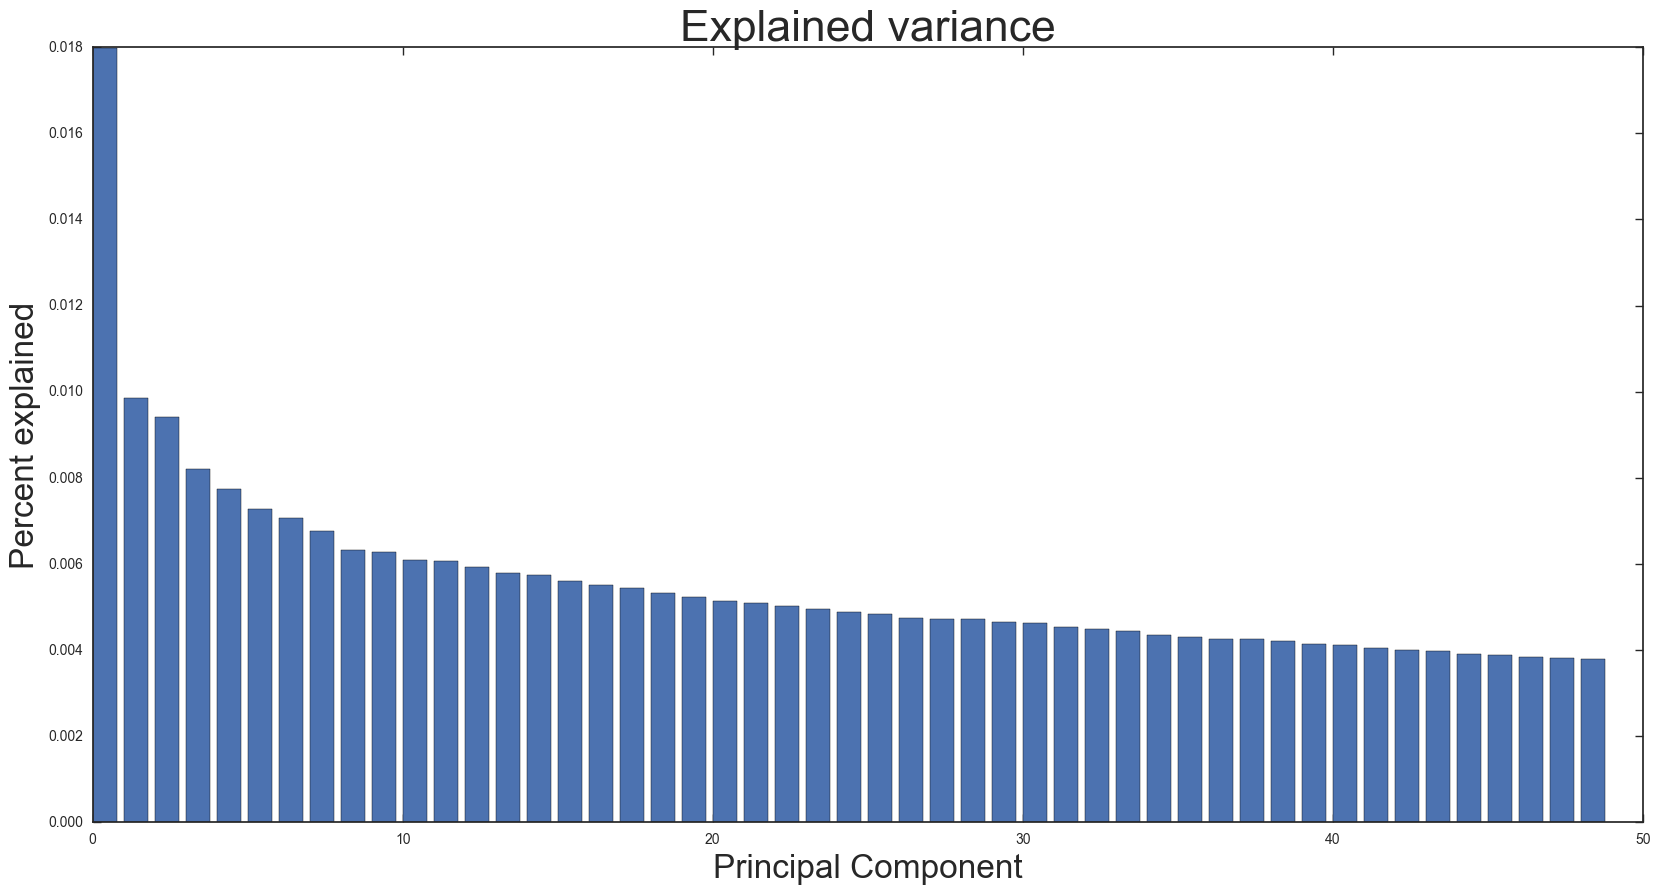

In [54]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

ax.bar([x for x in range(len(pca_obj.explained_variance_ratio_))],pca_obj.explained_variance_ratio_)

ax.set_title("Explained variance", size=32)
ax.set_ylabel("Percent explained", size=24)
ax.set_xlabel("Principal Component", size=24);

In [63]:
baseline = DB_baseline.fit(test_df)

In [66]:
baseline.fit_predict(test_df)

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 3, 1, 0, 0, 4, 2, 1,
       1, 0, 4, 0, 1, 0, 4, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 3, 4, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 3, 1, 4, 0, 2, 0, 4, 0, 1,
       0, 4, 0, 4, 0, 1, 0, 3, 1, 2, 0, 1, 4, 0, 0, 1, 4, 1, 0, 1, 4, 2, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 4, 0, 4, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 4,
       1, 3, 4, 2, 0, 0, 2, 0, 1, 0, 3, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 1, 3, 1, 0, 1, 0, 0, 4, 1, 0, 0, 1,
       1, 0, 4, 0, 3, 3, 3, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2,
       1, 1, 1, 1, 4, 0, 1, 4, 2, 3, 1, 4, 4, 1, 4, 1, 4, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 3, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 4, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 4, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 3, 4, 0, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1,